In [1]:
import numpy as np
import pylab
from tqdm.notebook import tqdm
import math
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data = data.iloc[2190:].resample('1D').first().ffill()

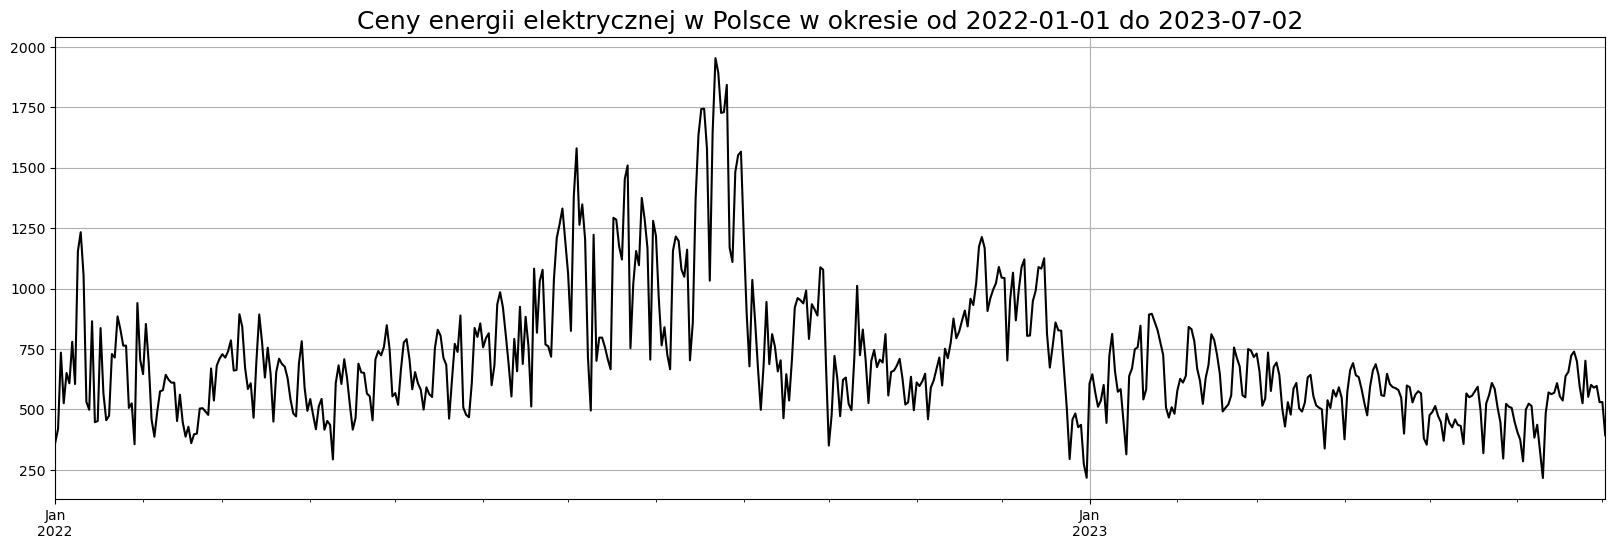

In [3]:
plt.rcParams["figure.figsize"] = (20,6)
data.plot(legend=False, color='black')
date_from = data.index[0].strftime('%Y-%m-%d')
date_to = data.index[-1].strftime('%Y-%m-%d')
plt.title(f'Ceny energii elektrycznej w Polsce w okresie od {date_from} do {date_to}', fontsize=18)
plt.xticks([datetime.strptime(f'{year}-01-01', '%Y-%m-%d') for year in [2022 + 1*i for i in range(2)]])
plt.xlabel('')
plt.grid()
plt.show()

In [7]:
class SDE:
    def __init__(self, drift, diffusion, data):
        """
        Args:
            drift (callable): Drift coefficient function.
            diffusion (callable): Diffusion coefficient function.
            data (pd.Series): Time series data used for the SDE.
        """
        self.drift = drift
        self.diffusion = diffusion
        self.data = data
        
        
    def estimate_parameters_mle(self, inital_guess_drift, inital_guess_diffusion):
        """
        Estimates parameters of stochastic differential equation
        dX_t = a(t, X_t)dt + b(t, X_t)dW_t, where:
        a - drift coefficient
        b - diffusion coefficient
        using quasi maximum likelihood estimation (QMLE) method.
        
        Args:
            inital_guess_drift: Initial guess for the drift coefficient parameters.
            inital_guess_diffusion: Initial guess for the diffusion coefficient parameters.

        """

        def log_likelihood(params, data):
            n = len(data)
            sum_log_likelihood = 0

            for i in range(1, n):
                # Compute the drift term
                drift = self.drift(*params[:len(inital_guess_drift)], data[i-1])

                # Compute the diffusion term
                diffusion = self.diffusion(*params[len(inital_guess_drift):], data[i-1])

                # Compute the log-likelihood contribution for this time step
                log_likelihood = -np.log(diffusion) - ((data[i] - data[i-1] - drift)**2) / (2 * diffusion**2)

                # Accumulate the log-likelihood contribution
                sum_log_likelihood += log_likelihood

            return -sum_log_likelihood
    
        # Initial parameter guess
        initial_guess = inital_guess_drift + inital_guess_diffusion
        # Perform maximum likelihood estimation
        result = minimize(log_likelihood, initial_guess, args=(self.data.values,), method='Nelder-Mead')

        self.drift = (lambda f: lambda x: f(*result.x[:len(inital_guess_drift)], x))(self.drift)
        self.diffusion = (lambda f: lambda x: f(*result.x[len(inital_guess_drift):], x))(self.diffusion)
        print(self.drift(1))
        return result.x


    @staticmethod
    def Wiener(h, n):
        """
        Generates Wiener path.
        
        Args:
            h: step size
            n: number of steps
            
        Returns:
            Array representing the Wiener path.
        """
        w = np.zeros(n+1)
        for i in range(1, n+1):
            w[i] = w[i-1]+np.sqrt(h)*np.random.normal(0, 1)
        return w
    

    def Euler_Maruyama(self, num_simulations, plot=True):
        """
        Simulates the Euler-Maruyama method for a given stochastic differential equation (SDE).

        Args:
            num_simulations: Number of simulations to perform.
            plot: Whether to plot the simulation results. Defaults to True.

        Returns:
            DataFrame containing the simulated SDE paths with dates as the index.
        """
        # Define SDE coefficients
        start_date = datetime(2022, 1, 1)
        end_date = datetime(2023, 7, 2)
        dates = self.data.index

        n = (end_date - start_date).days + 1
        x0 = self.data.values[0]
        h = 1 / n
        x = np.zeros((num_simulations, n))
        x[:, 0] = x0

        # Euler-Maruyama method
        for i in range(num_simulations):
            w = self.Wiener(h, n)
            for j in range(1, n):
                dW = w[j] - w[j-1]
                x[i, j] = x[i, j-1] + self.drift(x[i, j-1]) * h + self.diffusion(x[i, j-1]) * dW

        df = pd.DataFrame(x.T, columns=[f'Simulation {i+1}' for i in range(num_simulations)])
        df['Date'] = dates
        df = df.set_index('Date')

        if plot:
            plt.figure(figsize=(10, 6))
            for i in range(num_simulations):
                plt.plot(df.index, df[f'Simulation {i+1}'])
            data.plot(color='black')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.title(f'{num_simulations} SDE simulations with real data')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

        return df
    
    def goodness_of_fit_test(self, num_simulations, threshold, num_bins=30):
        """
        Performs the Chi-Squared Goodness-of-Fit test using the Euler-Maruyama method.

        Args:
            num_simulations: Number of simulations to perform.
            threshold: Significance level for the chi-squared test.
            num_bins (optional): Number of bins for histogram calculation. Defaults to 30.

        Returns:
            Tuple containing the chi-squared statistic, p-value, and result of the goodness-of-fit test.
        """
        # Generate simulated data based on the SDE model
        simulated_data = self.Euler_Maruyama(num_simulations, False).mean(axis=1).values

        # Calculate observed and expected frequencies
        observed_freq, _ = np.histogram(self.data.values, bins=num_bins)
        expected_freq, _ = np.histogram(simulated_data, bins=num_bins)

        # Perform chi-squared test
        chi2_stat, p_value = chi2_contingency(np.array([observed_freq, expected_freq]))[:2]

        # Determine if the model has goodness-of-fit or lack-of-fit
        result = "Lack-of-fit" if p_value < threshold else "Goodness-of-fit"

        return chi2_stat, p_value, result

## Model Blacka-Scholesa

Równanie Blacka-Scholesa:

$dX(t) = \mu X(t) dt + \sigma X(t) d W_t$

$X(t)$ - cena energii w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$, $\sigma > 0$

$W_t$ - proces Wienera

[0.0304998]
Results from MLE:
  drift: 0.030499795635036
  diffusion: 0.2737531650354289


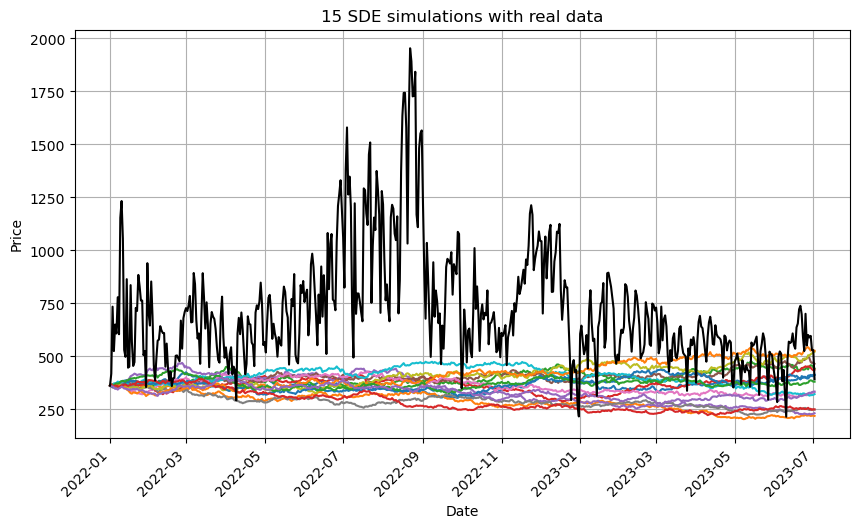

Results from Goodness-of-Fit test:
  Chi-square statistic: 531.2338589690052
  p-value: 1.0729528137212853e-93
  Result: Lack-of-fit


In [5]:
drift = lambda mu, x: mu * x
diffusion = lambda sigma, x: sigma * x
sde = SDE(drift, diffusion, data)
drift_coef, diffusion_coef = sde.estimate_parameters_mle([0.9], [0.5])
print(f'Results from MLE:\n  drift: {drift_coef}\n  diffusion: {diffusion_coef}')
sde.Euler_Maruyama(15)
chi2_stat, p_value, result = sde.goodness_of_fit_test(1000, 0.05)
print(f'Results from Goodness-of-Fit test:\n  Chi-square statistic: {chi2_stat}\n  p-value: {p_value}\n  Result: {result}')

## Model Ornsteina-Uhlenbecka

Model jest postaci:
    
$dX(t) = -\mu X(t) dt + \sigma d W_t$

$X(t)$ - cena energii w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$, $\sigma > 0$

$W_t$ - proces Wienera

[-0.02412889]
Results from MLE:
  drift: 0.0241288879410387
  diffusion: 167.63959110821582


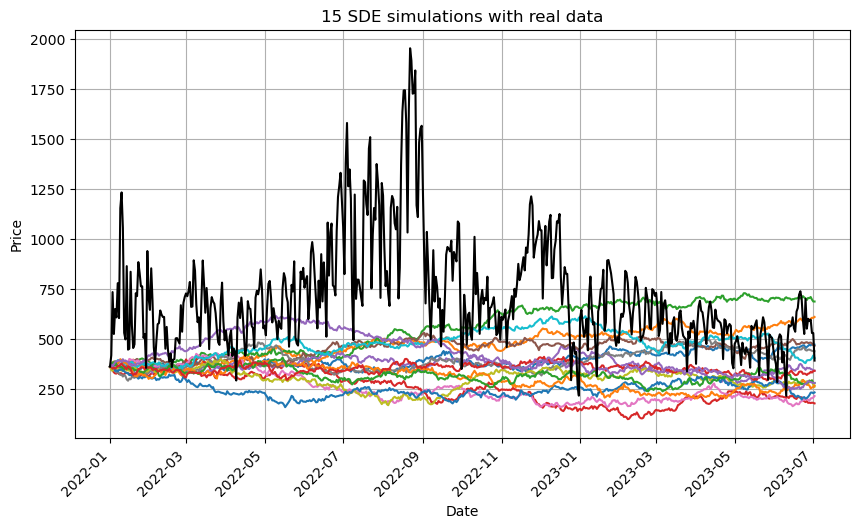

Results from Goodness-of-Fit test:
  Chi-square statistic: 306.51745222170945
  p-value: 4.169697817192749e-48
  Result: Lack-of-fit


In [6]:
drift = lambda mu, x: -mu * x
diffusion = lambda sigma, x: sigma * np.ones_like(x)
sde = SDE(drift, diffusion, data)
lb_drift = 0.0
ub_drift = 1.0
lb_diffusion = 20.0
ub_diffusion = 300.0
drift_coef, diffusion_coef = sde.estimate_parameters_mle([0.1], [100])
print(f'Results from MLE:\n  drift: {drift_coef}\n  diffusion: {diffusion_coef}')
sde.Euler_Maruyama(15)
chi2_stat, p_value, result = sde.goodness_of_fit_test(1000, 0.05)
print(f'Results from Goodness-of-Fit test:\n  Chi-square statistic: {chi2_stat}\n  p-value: {p_value}\n  Result: {result}')

## Model CIR

Model jest postaci:
    
$dX(t) = \kappa(\theta-X(t)) dt + \sigma \sqrt{X(t)}d W_t$

$X(t)$ - cena energii w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$, $\sigma > 0$

$W_t$ - proces Wienera

5.7584836359288794e-05
Results from MLE:
  drift: -6.82679214002932e-05, 0.15648762730541438
  diffusion: 6.449167269015034


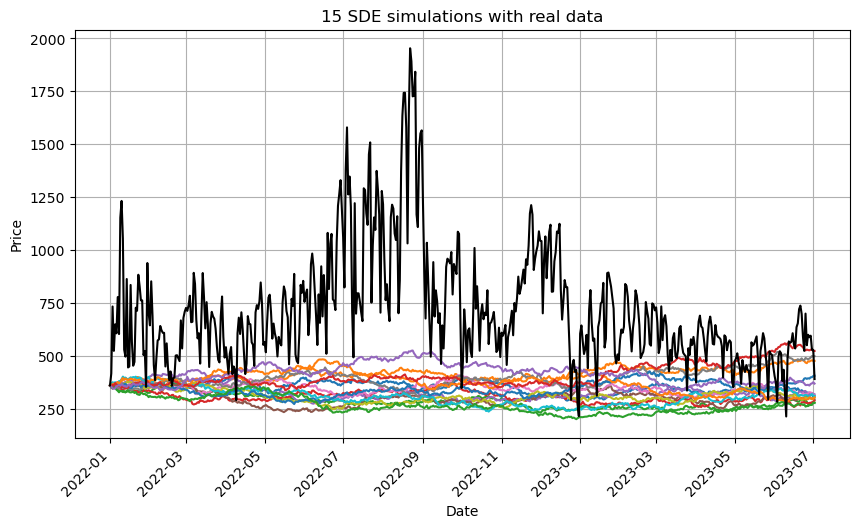

Results from Goodness-of-Fit test:
  Chi-square statistic: 295.31276610163735
  p-value: 6.8612872199281246e-46
  Result: Lack-of-fit


In [9]:
drift = lambda kappa, theta, x: kappa * (theta - x)
diffusion = lambda sigma, x: sigma * np.sqrt(x)
sde = SDE(drift, diffusion, data)
kappa_coef, theta_coef, sigma_coef = sde.estimate_parameters_mle([100, 0.1], [100])
print(f'Results from MLE:\n  drift: {kappa_coef}, {theta_coef}\n  diffusion: {sigma_coef}')
sde.Euler_Maruyama(15)
chi2_stat, p_value, result = sde.goodness_of_fit_test(1000, 0.05)
print(f'Results from Goodness-of-Fit test:\n  Chi-square statistic: {chi2_stat}\n  p-value: {p_value}\n  Result: {result}')

## Model Vasiceka

Model jest postaci:
    
$dX(t) = \kappa(\theta-X(t)) dt + \sigma d W_t$

$X(t)$ - cena energii w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$, $\sigma > 0$

$W_t$ - proces Wienera

-0.02131953436670933
Results from MLE:
  drift: 0.024094581178956482, 0.11517306699112903
  diffusion: 160.58198263427278


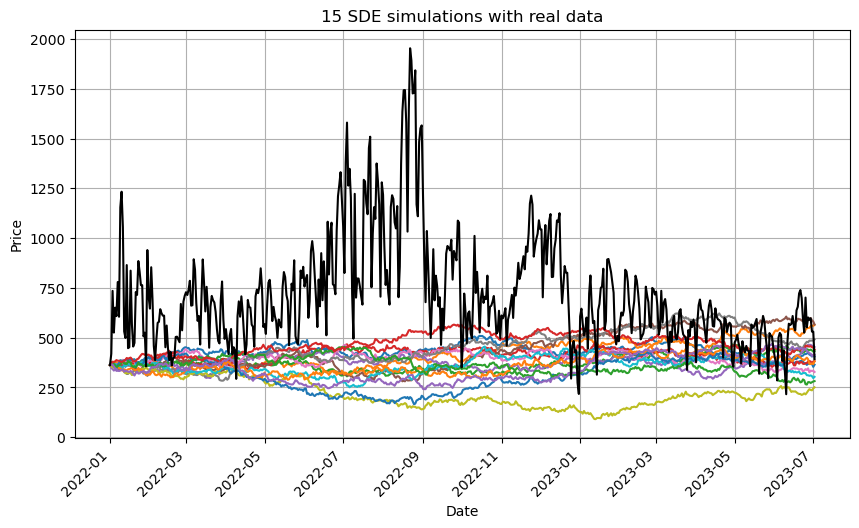

Results from Goodness-of-Fit test:
  Chi-square statistic: 267.3737038762798
  p-value: 2.113981144013512e-40
  Result: Lack-of-fit


In [10]:
drift = lambda kappa, theta, x: kappa * (theta - x)
diffusion = lambda sigma, x: sigma
sde = SDE(drift, diffusion, data)
kappa_coef, theta_coef, sigma_coef = sde.estimate_parameters_mle([100, 0.1], [100])
print(f'Results from MLE:\n  drift: {kappa_coef}, {theta_coef}\n  diffusion: {sigma_coef}')
sde.Euler_Maruyama(15)
chi2_stat, p_value, result = sde.goodness_of_fit_test(1000, 0.05)
print(f'Results from Goodness-of-Fit test:\n  Chi-square statistic: {chi2_stat}\n  p-value: {p_value}\n  Result: {result}')